In [1]:
# 5.2 합성곱 신경망 맛보기

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
train_dataset  = torchvision.datasets.FashionMNIST("data/minst", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_dataset  = torchvision.datasets.FashionMNIST("data/minst", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()])) 

In [5]:
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=100)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=100)

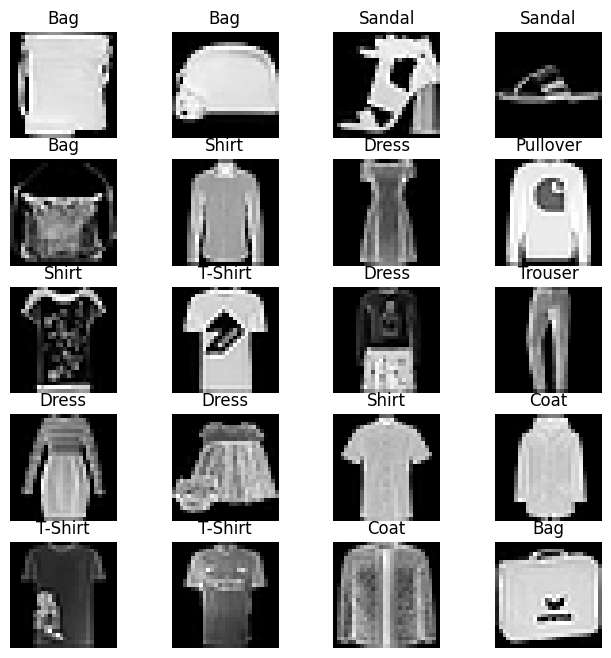

In [6]:
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'}

fig = plt.figure(figsize=(8,8));
columns = 4;
rows = 5;
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(train_dataset));
    img = train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

In [7]:
class FashionDNN(nn.Module):
    def __init__(self):
        super(FashionDNN,self).__init__()
        self.fc1 = nn.Linear(in_features=784,out_features=256)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=256,out_features=128)
        self.fc3 = nn.Linear(in_features=128,out_features=10)

    def forward(self,input_data):
        out = input_data.view(-1, 784)
        out = F.relu(self.fc1(out))
        out = self.drop(out)
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [8]:
learning_rate = 0.001;
model = FashionDNN();
model.to(device)

criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [9]:
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
    
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        outputs = model(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1
    
        if not (count % 50):    
            total = 0
            correct = 0        
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)            
                test = Variable(images.view(100, 1, 28, 28))            
                outputs = model(test)            
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()            
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

C:\Users\saint\anaconda3\envs\torch_book\lib\site-packages\torch\nn\functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration: 500, Loss: 0.6201011538505554, Accuracy: 83.23999786376953%
Iteration: 1000, Loss: 0.47468632459640503, Accuracy: 84.63999938964844%
Iteration: 1500, Loss: 0.3840789794921875, Accuracy: 83.90999603271484%
Iteration: 2000, Loss: 0.37687137722969055, Accuracy: 85.91999816894531%
Iteration: 2500, Loss: 0.23439086973667145, Accuracy: 85.68999481201172%
Iteration: 3000, Loss: 0.272969126701355, Accuracy: 86.66999816894531%


In [10]:
class FashionCNN(nn.Module):    
    def __init__(self):
        super(FashionCNN, self).__init__()        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )       
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)       
        return out

In [11]:
learning_rate = 0.001;
model = FashionCNN();
model.to(device)

criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [12]:
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
    
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        outputs = model(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1
    
        if not (count % 50):    
            total = 0
            correct = 0        
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)            
                test = Variable(images.view(100, 1, 28, 28))            
                outputs = model(test)            
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()            
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

Iteration: 500, Loss: 0.4899448752403259, Accuracy: 87.40999603271484%
Iteration: 1000, Loss: 0.3312075436115265, Accuracy: 88.48999786376953%
Iteration: 1500, Loss: 0.31559574604034424, Accuracy: 88.63999938964844%
Iteration: 2000, Loss: 0.20016717910766602, Accuracy: 89.45999908447266%
Iteration: 2500, Loss: 0.14526648819446564, Accuracy: 89.65999603271484%
Iteration: 3000, Loss: 0.1572219878435135, Accuracy: 90.13999938964844%


In [13]:
#5.3.1 특성 추출 기법

In [33]:
import os
import time
import copy
import glob
import cv2
import shutil

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

In [34]:
data_path = 'data/catanddog/train'
    
transform = transforms.Compose(
                [
                    transforms.Resize([256, 256]),
                    transforms.RandomResizedCrop(224),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                ])
train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=8,
    shuffle=True
)

print(len(train_dataset))

529


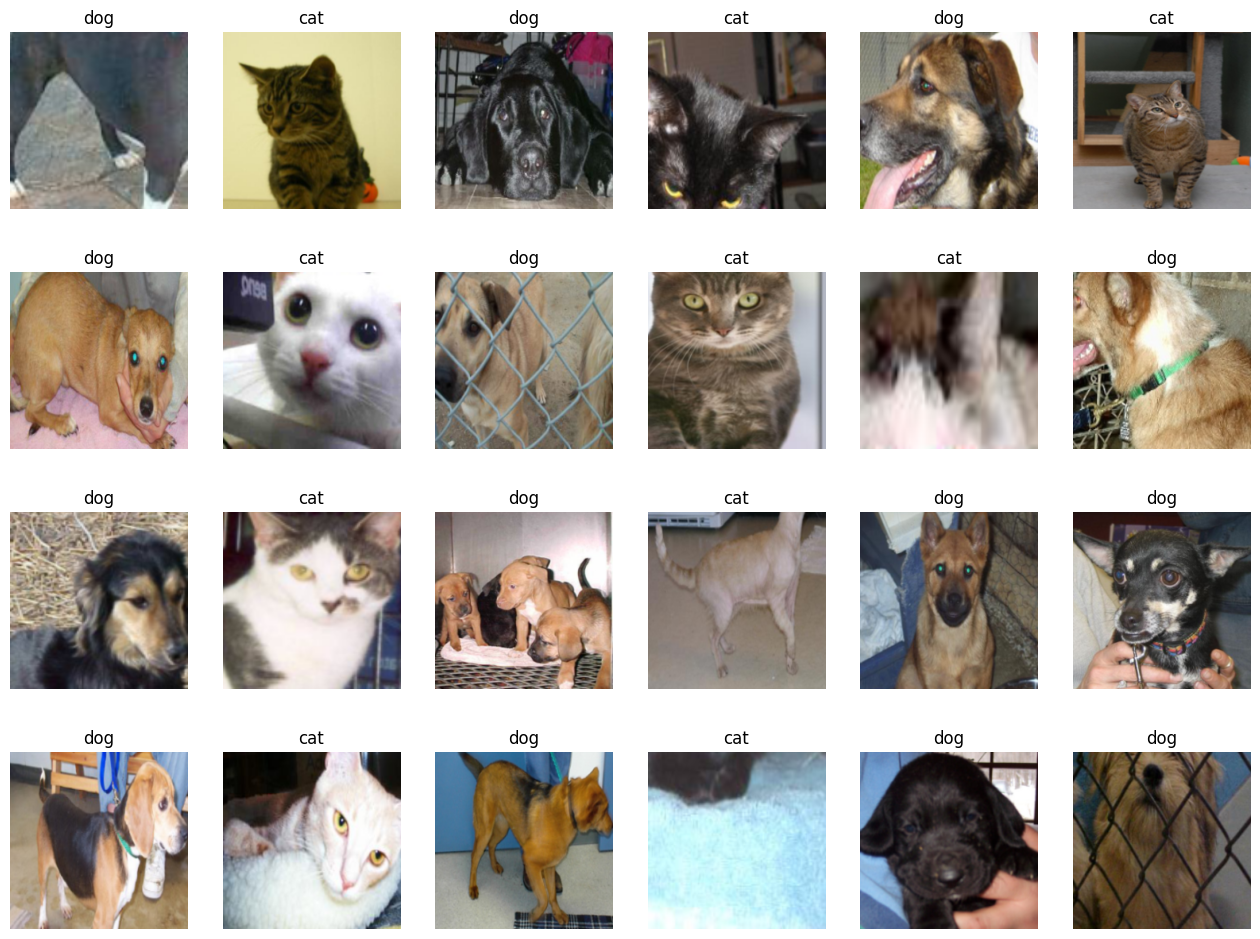

In [35]:
samples, labels = next(iter(train_loader))
classes = {0:'cat', 1:'dog'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [36]:
resnet18 = models.resnet18(pretrained=True)

In [37]:
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
set_parameter_requires_grad(resnet18)

In [38]:
resnet18.fc = nn.Linear(512, 2)

In [39]:
for name, param in resnet18.named_parameters():
    if param.requires_grad:
        print(name, param.data)

fc.weight tensor([[ 0.0295, -0.0150,  0.0324,  ..., -0.0423,  0.0266, -0.0353],
        [ 0.0263, -0.0074, -0.0434,  ...,  0.0050, -0.0288,  0.0190]])
fc.bias tensor([-0.0038,  0.0112])


In [40]:
model = models.resnet18(pretrained = True)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(512, 2)
for param in model.fc.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [41]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13, is_train=True):
    since = time.time()    
    acc_history = []
    loss_history = []
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            model.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)        
        torch.save(model.state_dict(), os.path.join('data/catanddog/', '{0:0=2d}.pth'.format(epoch)))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))    
    return acc_history, loss_history

In [42]:
params_to_update = []
for name,param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)
            
optimizer = optim.Adam(params_to_update)

	 fc.weight
	 fc.bias


In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)

Epoch 0/12
----------
Loss: 0.5260 Acc: 0.7524

Epoch 1/12
----------
Loss: 0.3079 Acc: 0.8904

Epoch 2/12
----------
Loss: 0.2564 Acc: 0.9074

Epoch 3/12
----------
Loss: 0.1958 Acc: 0.9395

Epoch 4/12
----------
Loss: 0.1994 Acc: 0.9319

Epoch 5/12
----------
Loss: 0.1880 Acc: 0.9244

Epoch 6/12
----------
Loss: 0.1920 Acc: 0.9187

Epoch 7/12
----------
Loss: 0.1902 Acc: 0.9187

Epoch 8/12
----------
Loss: 0.1793 Acc: 0.9433

Epoch 9/12
----------
Loss: 0.1470 Acc: 0.9338

Epoch 10/12
----------
Loss: 0.1812 Acc: 0.9301

Epoch 11/12
----------
Loss: 0.1296 Acc: 0.9546

Epoch 12/12
----------
Loss: 0.1521 Acc: 0.9282

Training complete in 1m 13s
Best Acc: 0.954631


In [44]:
test_path = 'data/catanddog/test'

transform = transforms.Compose(
                [
                    transforms.Resize(224),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                ])
test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

print(len(test_dataset))

107


In [45]:
def eval_model(model, dataloaders, device):
    since = time.time()    
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('data/catanddog/' + '*.pth')
    saved_models.sort()
    print('saved_model', saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)

            _, preds = torch.max(outputs.data, 1)           
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0
            running_corrects += preds.eq(labels).int().sum()
            
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print('Acc: {:.4f}'.format(epoch_acc))
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    
    return acc_history

In [46]:
val_acc_hist = eval_model(resnet18, test_loader, device)

saved_model ['data/catanddog\\00.pth', 'data/catanddog\\01.pth', 'data/catanddog\\02.pth', 'data/catanddog\\03.pth', 'data/catanddog\\04.pth', 'data/catanddog\\05.pth', 'data/catanddog\\06.pth', 'data/catanddog\\07.pth', 'data/catanddog\\08.pth', 'data/catanddog\\09.pth', 'data/catanddog\\10.pth', 'data/catanddog\\11.pth', 'data/catanddog\\12.pth']
Loading model data/catanddog\00.pth
Acc: 0.9252

Loading model data/catanddog\01.pth
Acc: 0.9159

Loading model data/catanddog\02.pth
Acc: 0.9533

Loading model data/catanddog\03.pth
Acc: 0.9533

Loading model data/catanddog\04.pth
Acc: 0.9439

Loading model data/catanddog\05.pth
Acc: 0.9439

Loading model data/catanddog\06.pth
Acc: 0.9533

Loading model data/catanddog\07.pth
Acc: 0.9346

Loading model data/catanddog\08.pth
Acc: 0.9533

Loading model data/catanddog\09.pth
Acc: 0.9533

Loading model data/catanddog\10.pth
Acc: 0.9533

Loading model data/catanddog\11.pth
Acc: 0.9533

Loading model data/catanddog\12.pth
Acc: 0.9533

Validation c

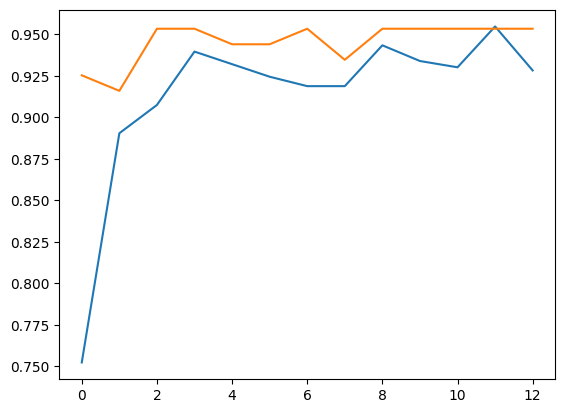

In [47]:
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

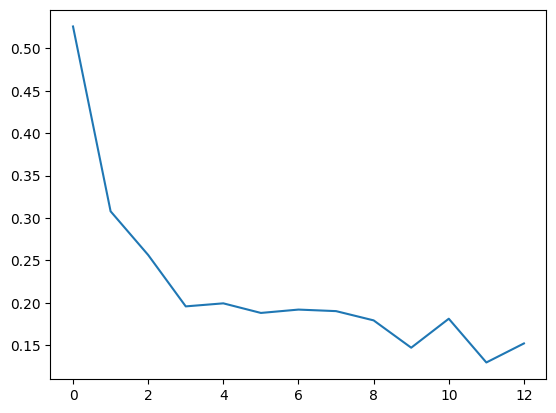

In [48]:
plt.plot(train_loss_hist)
plt.show()

In [49]:
def im_convert(tensor):  
    image=tensor.clone().detach().numpy()  
    image=image.transpose(1,2,0)  
    image=image*(np.array((0.5,0.5,0.5))+np.array((0.5,0.5,0.5)))  
    image=image.clip(0,1)  
    return image  

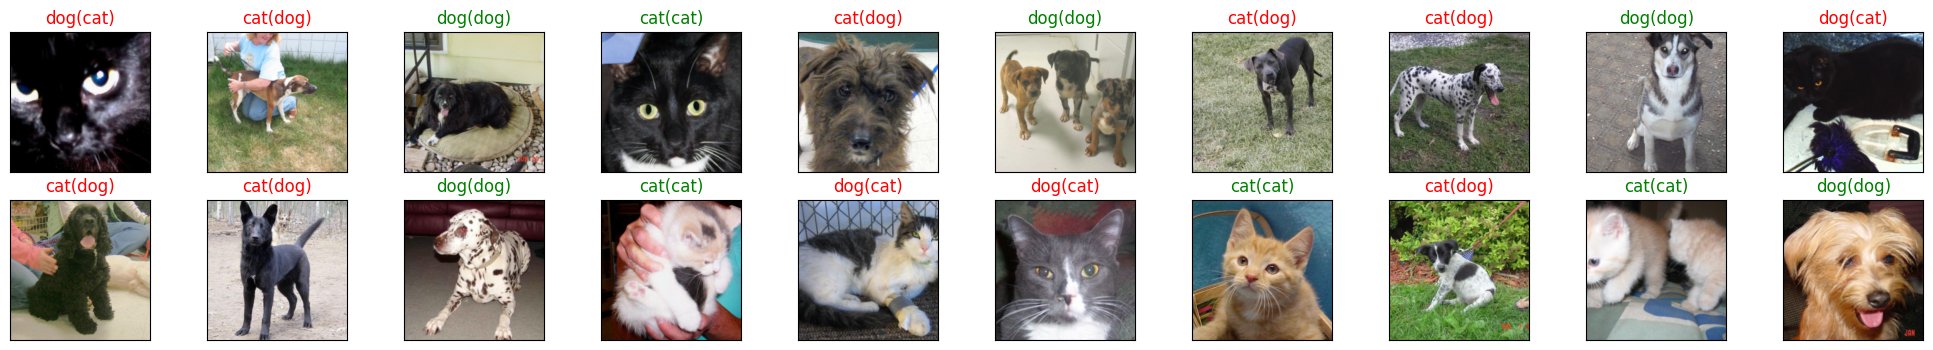

<Figure size 640x480 with 0 Axes>

In [50]:
classes = {0:'cat', 1:'dog'}

dataiter=iter(test_loader)  
images,labels=next(dataiter)
output=model(images)  
_,preds=torch.max(output,1) 

fig=plt.figure(figsize=(25,4))  
for idx in np.arange(20):  
    ax=fig.add_subplot(2,10,idx+1,xticks=[],yticks=[])  
    plt.imshow(im_convert(images[idx]))  
    a.set_title(classes[labels[i].item()])
    ax.set_title("{}({})".format(str(classes[preds[idx].item()]),str(classes[labels[idx].item()])),color=("green" if preds[idx]==labels[idx] else "red"))  
plt.show()  
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [ ]:
# 5.4.1 특성 맵 시각화

In [51]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.transforms import ToTensor
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [52]:
class XAI(torch.nn.Module):
    def __init__(self, num_classes=2):
        super(XAI, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(64, 64, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(128, 128, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(256, 256, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(256, 256, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512, 512, bias=False),
            nn.Dropout(0.5),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 512)
        x = self.classifier(x)
        return F.log_softmax(x)

In [53]:
model=XAI()
model.to(device)
model.eval()

XAI(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True

In [54]:
class LayerActivations:
    features=[]
    def __init__(self, model, layer_num):
        self.hook = model[layer_num].register_forward_hook(self.hook_fn)
   
    def hook_fn(self, module, input, output):
        self.features = output.cpu().detach().numpy()
 
    def remove(self): 
        self.hook.remove()

torch.Size([1, 3, 100, 100])


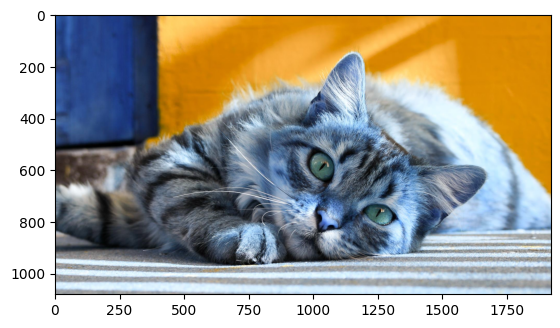

In [55]:
img=cv2.imread("data/cat.jpg")   
plt.imshow(img)
img = cv2.resize(img, (100, 100), interpolation=cv2.INTER_LINEAR)
img = ToTensor()(img).unsqueeze(0)
print(img.shape)

In [56]:
result = LayerActivations(model.features, 0)

model(img.cuda())
activations = result.features

C:\Users\flt.DESKTOP-I2KQP96\AppData\Local\Temp\ipykernel_7264\1460188688.py:75: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


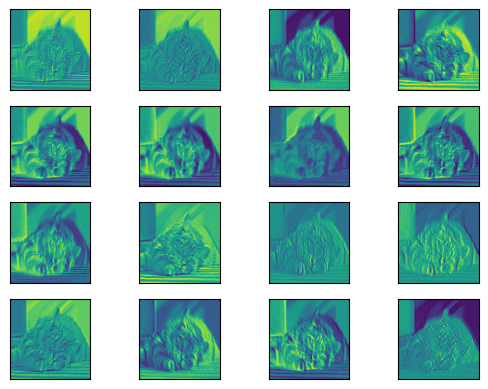

<Figure size 1200x800 with 0 Axes>

In [57]:
fig, axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10+column])
plt.show()

In [58]:
result = LayerActivations(model.features, 20)

model(img.cuda())
activations = result.features

C:\Users\flt.DESKTOP-I2KQP96\AppData\Local\Temp\ipykernel_7264\1460188688.py:75: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


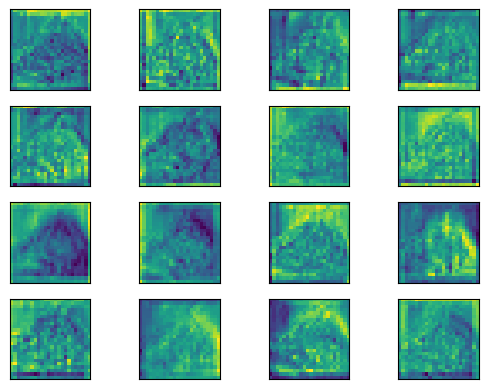

<Figure size 1200x800 with 0 Axes>

In [59]:
fig, axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10+column])
plt.show()

In [60]:
result = LayerActivations(model.features, 40)

model(img.cuda())
activations = result.features

C:\Users\flt.DESKTOP-I2KQP96\AppData\Local\Temp\ipykernel_7264\1460188688.py:75: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


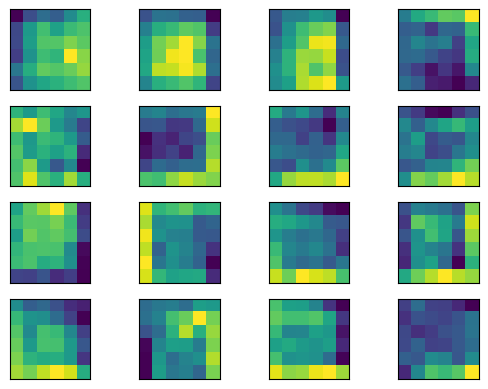

<Figure size 1200x800 with 0 Axes>

In [61]:
fig, axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10+column])
plt.show()